In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test-dataset/test.csv
/kaggle/input/preprocessd/preprocessed1.csv
/kaggle/input/image-dataset/images/7016310030.png
/kaggle/input/image-dataset/images/3422059085.png
/kaggle/input/image-dataset/images/7504010480.png
/kaggle/input/image-dataset/images/8121100325.png
/kaggle/input/image-dataset/images/9352900222.png
/kaggle/input/image-dataset/images/624110050.png
/kaggle/input/image-dataset/images/5244801275.png
/kaggle/input/image-dataset/images/2725069156.png
/kaggle/input/image-dataset/images/8849700040.png
/kaggle/input/image-dataset/images/4055700920.png
/kaggle/input/image-dataset/images/1330290160.png
/kaggle/input/image-dataset/images/7335400065.png
/kaggle/input/image-dataset/images/3235100080.png
/kaggle/input/image-dataset/images/3354400060.png
/kaggle/input/image-dataset/images/6127010890.png
/kaggle/input/image-dataset/images/7452500365.png
/kaggle/input/image-dataset/images/1426300842.png
/kaggle/input/image-dataset/images/993002127.png
/kaggle/input/image-da

In [3]:

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import models, transforms
from PIL import Image

from sklearn.metrics import mean_squared_error, r2_score

In [4]:
df=pd.read_csv("/kaggle/input/preprocessd/preprocessed1.csv")

In [5]:
df["id"].duplicated().sum()

np.int64(99)

In [6]:
df=df.drop_duplicates(subset=["id"])

In [7]:
df.shape

(16110, 20)

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
unique_ids = df["id"].unique()

# 2️⃣ Split IDs
train_ids, val_ids = train_test_split(
    unique_ids,
    test_size=0.2,
    random_state=42,
    shuffle=True
)


# 4️⃣ Save indices
np.save("/kaggle/working/train_id.npy", train_ids)
np.save("/kaggle/working/val_id.npy", val_ids)


In [11]:
train_ids.shape
val_ids.shape

(3222,)

In [12]:
train_df = df[df["id"].isin(train_ids)].reset_index(drop=True)
val_df   = df[df["id"].isin(val_ids)].reset_index(drop=True)

print("Train size:", len(train_df))
print("Val size:", len(val_df))


Train size: 12888
Val size: 3222


In [13]:
train_df.head()

,id,price,sqft_living,floors,waterfront,grade,zipcode,basement_ratio,above_ratio,rlt_size,rlt_lot_size,quality_liv,quality_cond,view_flag,water_view,luxury_bool,lot_util,bath_per_bed,house_life,ren_age
0,6700390210,245000,1600,2.0,0,7,98031,0.0,1.0,0.930233,0.572882,11200,28,0,0,0,0.573888,0.833333,22,22
1,7212660540,200000,1720,2.0,0,8,98003,0.0,1.0,0.919786,0.769499,13760,24,0,0,0,0.199120,0.625000,21,21
2,7760400350,232000,1280,1.0,0,7,98042,0.0,1.0,0.805031,0.976374,8960,21,0,0,0,0.095837,0.666667,20,20
3,464001025,722500,2600,2.0,0,8,98117,0.3,0.7,1.300000,0.564705,20800,24,0,0,0,0.509804,0.875000,11,11
4,3432500486,299995,1060,1.0,0,6,98155,0.0,1.0,0.572973,0.625089,6360,24,0,0,0,0.147222,0.500000,63,63


## Work on Image

In [14]:
class PropertyImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.df = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = int(self.df.iloc[idx]["id"])   # force int
        img_path = os.path.join(self.img_dir, f"{img_id}.png")
        image = Image.open(img_path).convert("RGB")
    
        price = torch.tensor(
            np.log1p(self.df.iloc[idx]["price"]),
            dtype=torch.float32
        )

        if self.transform:
            image = self.transform(image)

        return image, price


In [112]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [16]:
IMG_DIR = "/kaggle/input/image-dataset/images"

train_dataset = PropertyImageDataset(train_df, IMG_DIR, train_transform)
val_dataset   = PropertyImageDataset(val_df, IMG_DIR, val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


In [17]:
model = models.resnet50(pretrained=True)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 211MB/s] 


In [18]:
num_features = model.fc.in_features

model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 1)
)


In [19]:
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

criterion = nn.MSELoss()  # training objective
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)


cuda


In [21]:
from sklearn.metrics import root_mean_squared_error

In [22]:
def evaluate(model, loader):
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for imgs, prices in loader:
            imgs = imgs.to(device)
            prices = prices.to(device)

            outputs = model(imgs).squeeze()          # 1️⃣ forward pass
            outputs = torch.clamp(outputs, -10, 15)  # 2️⃣ clamp log-price

            preds.extend(np.expm1(outputs.cpu().numpy()))
            targets.extend(np.expm1(prices.cpu().numpy()))

    rmse = root_mean_squared_error(targets, preds)
    r2 = r2_score(targets, preds)

    return rmse, r2


In [23]:
best_rmse = float("inf")
patience = 3
patience_counter = 0

# Stage 1 optimizer (head only)
optimizer = torch.optim.Adam(
    model.fc.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

for epoch in range(20):
    model.train()
    running_loss = 0.0

    for imgs, prices in train_loader:
        imgs = imgs.to(device)
        prices = prices.to(device)

        optimizer.zero_grad()
        outputs = model(imgs).squeeze()
        loss = criterion(outputs, prices)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    val_rmse, val_r2 = evaluate(model, val_loader)

    print(f"Epoch {epoch+1}")
    print(f"Train MSE (log-price): {train_loss:.4f}")
    print(f"Val RMSE (price): {val_rmse:.4f} | Val R²: {val_r2:.4f}")

    # ----- Early stopping -----
    if val_rmse < best_rmse:
        best_rmse = val_rmse
        patience_counter = 0
        torch.save(model.state_dict(), "best_resnet.pt")
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

    # ----- Step 13: Fine-tuning after plateau -----
    if epoch == 5:
        print("Unfreezing layer4 for fine-tuning")

        for name, param in model.named_parameters():
            if "layer4" in name:
                param.requires_grad = True

        optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=1e-4,
            weight_decay=1e-4
        )


Epoch 1
Train MSE (log-price): 2.6908
Val RMSE (price): 557539.2183 | Val R²: -1.5429
Epoch 2
Train MSE (log-price): 1.0820
Val RMSE (price): 518250.6748 | Val R²: -1.1972
Epoch 3
Train MSE (log-price): 1.0471
Val RMSE (price): 473261.5909 | Val R²: -0.8322
Epoch 4
Train MSE (log-price): 0.9857
Val RMSE (price): 426682.1817 | Val R²: -0.4893
Epoch 5
Train MSE (log-price): 0.9940
Val RMSE (price): 442499.1880 | Val R²: -0.6018
Epoch 6
Train MSE (log-price): 0.9443
Val RMSE (price): 446689.6044 | Val R²: -0.6323
Unfreezing layer4 for fine-tuning
Epoch 7
Train MSE (log-price): 0.7617
Val RMSE (price): 397788.6930 | Val R²: -0.2945
Epoch 8
Train MSE (log-price): 0.6035
Val RMSE (price): 312095.5258 | Val R²: 0.2032
Epoch 9
Train MSE (log-price): 0.5489
Val RMSE (price): 365290.6542 | Val R²: -0.0916
Epoch 10
Train MSE (log-price): 0.5350
Val RMSE (price): 341502.6278 | Val R²: 0.0460
Epoch 11
Train MSE (log-price): 0.5057
Val RMSE (price): 327547.0198 | Val R²: 0.1223
Early stopping trigge

In [24]:
full_dataset = PropertyImageDataset(
    dataframe=df,
    img_dir=IMG_DIR,
    transform=val_transform   # no augmentation for embeddings
)

full_loader = DataLoader(
    full_dataset,
    batch_size=32,
    shuffle=False,   # 🔴 CRITICAL
    num_workers=2
)


In [25]:
model.load_state_dict(torch.load("best_resnet.pt"))
model.eval()

encoder = nn.Sequential(*list(model.children())[:-1]).to(device)
encoder.eval()


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [26]:
# save embeddings keyed by id (SAFE, order-independent)

emb_dict = {}
batch_size = full_loader.batch_size

with torch.no_grad():
    for batch_idx, (imgs, _) in enumerate(full_loader):
        imgs = imgs.to(device)
        emb = encoder(imgs)
        emb = emb.reshape(emb.size(0), -1).cpu()   # use reshape (ConvNeXt safe)

        # get corresponding ids for this batch
        start = batch_idx * batch_size
        end = start + emb.size(0)
        ids = df.iloc[start:end]["id"].values

        for i, id_val in enumerate(ids):
            emb_dict[int(id_val)] = emb[i]



In [27]:
# save to disk
torch.save(emb_dict, "/kaggle/working/res_embeddings_id.pt")


In [28]:
test_df=pd.read_csv("/kaggle/input/test-dataset/test.csv")

In [29]:
test_IMG_DIR="/kaggle/input/test-image/test_images"

In [30]:
class TestImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform):
        self.df = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = int(self.df.iloc[idx]["id"])
        img_path = os.path.join(self.img_dir, f"{img_id}.png")
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image


In [31]:
test_dataset = TestImageDataset(
    dataframe=test_df,
    img_dir=test_IMG_DIR,
    transform=val_transform   # ❗ no augmentation
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,   # 🔴 CRITICAL
    num_workers=2
)


In [32]:
# save TEST embeddings keyed by id (order-independent)

test_emb_dict = {}
batch_size = test_loader.batch_size

with torch.no_grad():
    for batch_idx, imgs in enumerate(test_loader):
        imgs = imgs.to(device)
        emb = encoder(imgs)
        emb = emb.reshape(emb.size(0), -1).cpu()

        # get corresponding ids for this batch
        start = batch_idx * batch_size
        end = start + emb.size(0)
        ids = test_df.iloc[start:end]["id"].values

        for i, id_val in enumerate(ids):
            test_emb_dict[int(id_val)] = emb[i]

# save
torch.save(test_emb_dict, "/kaggle/working/test_image_embeddings_by_id.pt")


In [33]:
torch.save(test_emb_dict, "/kaggle/working/test_resnet_id_embeddings.pt")


# Efficient Net Model

In [34]:
import timm


/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [92]:
model = timm.create_model(
    "efficientnet_b0",
    pretrained=True
)


In [93]:
in_features = model.classifier.in_features

model.classifier = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 1)
)


In [94]:
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True


In [95]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss()   # log-price training
optimizer = torch.optim.Adam(
    model.classifier.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)


In [96]:
best_rmse = float("inf")
patience = 3
patience_counter = 0

# Stage-1 optimizer (head only)
optimizer = torch.optim.Adam(
    model.classifier.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)


In [97]:
EPOCHS = 28

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for imgs, prices in train_loader:
        imgs = imgs.to(device)
        prices = prices.to(device)

        optimizer.zero_grad()
        outputs = model(imgs).squeeze()
        loss = criterion(outputs, prices)   # MSE on log-price
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    if epoch == 0:
        continue

    train_loss = running_loss / len(train_loader)
    val_rmse, val_r2 = evaluate(model, val_loader)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train MSE (log-price): {train_loss:.4f}")
    print(f"Val RMSE (price): {val_rmse:.4f} | Val R²: {val_r2:.4f}")

    # ---------- Early Stopping ----------
    if val_rmse < best_rmse:
        best_rmse = val_rmse
        patience_counter = 0
        torch.save(model.state_dict(), "best_efficientnet.pt")
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

    # ---------- Fine-tuning (last block only) ----------
    if epoch == 5:
        print("Unfreezing EfficientNet last block")

        for name, param in model.named_parameters():
            if "blocks.6" in name:   # last block for B3
                param.requires_grad = True

        optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=1e-4,
            weight_decay=1e-4
        )


Epoch 2/28
Train MSE (log-price): 3.9240
Val RMSE (price): 1092772.0788 | Val R²: -8.7688
Epoch 3/28
Train MSE (log-price): 2.4239
Val RMSE (price): 1169693.1990 | Val R²: -10.1924
Epoch 4/28
Train MSE (log-price): 1.7396
Val RMSE (price): 743864.7254 | Val R²: -3.5266
Epoch 5/28
Train MSE (log-price): 1.2930
Val RMSE (price): 790182.0350 | Val R²: -4.1078
Epoch 6/28
Train MSE (log-price): 1.1783
Val RMSE (price): 672109.3241 | Val R²: -2.6954
Unfreezing EfficientNet last block
Epoch 7/28
Train MSE (log-price): 0.8040
Val RMSE (price): 405301.6528 | Val R²: -0.3438
Epoch 8/28
Train MSE (log-price): 0.6639
Val RMSE (price): 371138.7099 | Val R²: -0.1268
Epoch 9/28
Train MSE (log-price): 0.6195
Val RMSE (price): 375311.4185 | Val R²: -0.1523
Epoch 10/28
Train MSE (log-price): 0.5663
Val RMSE (price): 360663.4951 | Val R²: -0.0641
Epoch 11/28
Train MSE (log-price): 0.5334
Val RMSE (price): 331650.8843 | Val R²: 0.1002
Epoch 12/28
Train MSE (log-price): 0.5022
Val RMSE (price): 324890.5035

In [98]:
model.load_state_dict(torch.load("best_efficientnet.pt"))
model.eval()


EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

In [99]:
encoder = nn.Sequential(*list(model.children())[:-1]).to(device)
encoder.eval()


Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (2): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d

In [100]:
# save embeddings keyed by id (SAFE, order-independent)

emb_dict = {}
batch_size = full_loader.batch_size

with torch.no_grad():
    for batch_idx, (imgs, _) in enumerate(full_loader):
        imgs = imgs.to(device)
        emb = encoder(imgs)
        emb = emb.reshape(emb.size(0), -1).cpu()   # use reshape (ConvNeXt safe)

        # get corresponding ids for this batch
        start = batch_idx * batch_size
        end = start + emb.size(0)
        ids = df.iloc[start:end]["id"].values

        for i, id_val in enumerate(ids):
            emb_dict[int(id_val)] = emb[i]



In [110]:
torch.save(emb_dict, "/kaggle/working/efficient_embeddings_idnew.pt")


In [103]:
test_df=pd.read_csv("/kaggle/input/test-dataset/test.csv")

In [105]:
test_IMG_DIR="/kaggle/input/test-image/test_images"

In [106]:
test_df=test_df.drop_duplicates(subset=["id"])

In [107]:
test_df.shape

(5396, 20)

In [108]:
test_dataset = TestImageDataset(
    dataframe=test_df,
    img_dir=test_IMG_DIR,
    transform=val_transform   
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False, 
    num_workers=2
)


In [111]:


test_emb_dict = {}
batch_size = test_loader.batch_size

with torch.no_grad():
    for batch_idx, imgs in enumerate(test_loader):
        imgs = imgs.to(device)
        emb = encoder(imgs)
        emb = emb.reshape(emb.size(0), -1).cpu()

        # get corresponding ids for this batch
        start = batch_idx * batch_size
        end = start + emb.size(0)
        ids = test_df.iloc[start:end]["id"].values

        for i, id_val in enumerate(ids):
            test_emb_dict[int(id_val)] = emb[i]

# save
torch.save(test_emb_dict, "/kaggle/working/test_efficient_embeddings_by_idnew.pt")


# CONVNEXT_tiny

In [54]:
model = timm.create_model(
    "convnext_tiny",
    pretrained=True
)


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

In [55]:
in_features = model.head.fc.in_features

model.head.fc = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 1)
)


In [56]:
for param in model.parameters():
    param.requires_grad = False

for param in model.head.parameters():
    param.requires_grad = True


In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss()   # log-price training

optimizer = torch.optim.Adam(
    model.head.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)


In [58]:
best_rmse = float("inf")
patience = 3
patience_counter = 0

EPOCHS = 20

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for imgs, prices in train_loader:
        imgs = imgs.to(device)
        prices = prices.to(device)

        optimizer.zero_grad()
        outputs = model(imgs).squeeze()
        loss = criterion(outputs, prices)   # MSE on log-price
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    val_rmse, val_r2 = evaluate(model, val_loader)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train MSE (log-price): {train_loss:.4f}")
    print(f"Val RMSE (price): {val_rmse:.4f} | Val R²: {val_r2:.4f}")

    # ---------- Early stopping ----------
    if val_rmse < best_rmse:
        best_rmse = val_rmse
        patience_counter = 0
        torch.save(model.state_dict(), "best_convnext.pt")
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

    # ---------- Fine-tuning (last ConvNeXt stage) ----------
    if epoch == 5:
        print("Unfreezing ConvNeXt last stage")

        for name, param in model.named_parameters():
            if "stages.3" in name:   # last stage in ConvNeXt-Tiny
                param.requires_grad = True

        optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=1e-4,
            weight_decay=1e-4
        )


Epoch 1/20
Train MSE (log-price): 2.4976
Val RMSE (price): 427982.4556 | Val R²: -0.4984
Epoch 2/20
Train MSE (log-price): 0.9435
Val RMSE (price): 585152.8711 | Val R²: -1.8010
Epoch 3/20
Train MSE (log-price): 0.8946
Val RMSE (price): 450005.1854 | Val R²: -0.6566
Epoch 4/20
Train MSE (log-price): 0.8480
Val RMSE (price): 374468.0768 | Val R²: -0.1471
Epoch 5/20
Train MSE (log-price): 0.8426
Val RMSE (price): 446115.4750 | Val R²: -0.6281
Epoch 6/20
Train MSE (log-price): 0.8133
Val RMSE (price): 455446.6024 | Val R²: -0.6969
Unfreezing ConvNeXt last stage
Epoch 7/20
Train MSE (log-price): 0.7398
Val RMSE (price): 324893.4446 | Val R²: 0.1365
Epoch 8/20
Train MSE (log-price): 0.5281
Val RMSE (price): 307762.8298 | Val R²: 0.2252
Epoch 9/20
Train MSE (log-price): 0.5074
Val RMSE (price): 276465.9131 | Val R²: 0.3747
Epoch 10/20
Train MSE (log-price): 0.5002
Val RMSE (price): 276673.4023 | Val R²: 0.3738
Epoch 11/20
Train MSE (log-price): 0.4815
Val RMSE (price): 306478.0127 | Val R²: 

In [71]:
target_layer = model.stages[-1].blocks[-1]


In [67]:
import torch
import torch.nn.functional as F
import cv2


class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.target_layer.register_forward_hook(self.forward_hook)
        self.target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activations = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, x):
        self.model.zero_grad()
        out = self.model(x)
        out.backward(torch.ones_like(out))

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)

        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / cam.max()

        return cam


In [69]:
model.load_state_dict(torch.load("best_convnext.pt"))
model.eval()


ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=384, out_features=96, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)


In [60]:
encoder = nn.Sequential(*list(model.children())[:-1]).to(device)
encoder.eval()


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
  )
  (1): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=384, out_features=96, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
      

In [88]:
# load image tensor (same transform as training)
  # [1, 3, H, W]

model.eval()
gradcam = GradCAM(model, target_layer)

cam = gradcam.generate(img)[0].detach().cpu().numpy()



## Grad-Cam Use on ConvNxt

In [87]:
from PIL import Image

img_path="/kaggle/input/test-image/test_images/1005000220.png"
img = Image.open(img_path).convert("RGB")

# apply SAME validation transform used in training
img_tensor = val_transform(img)    # [3, H, W]

# add batch dimension
img = img_tensor.unsqueeze(0).to(device)


In [89]:
import cv2

original_img = cv2.imread(img_path)                 # load
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
original_img = np.ascontiguousarray(original_img)  # 🔴 important


In [90]:
def overlay_cam(img, cam):
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    return cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

# original image (H, W, 3) in ui4nt8
overlay = overlay_cam(original_img, cam)


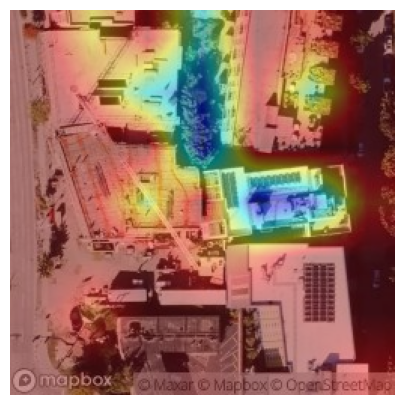

In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.imshow(overlay)
plt.axis("off")
plt.show()


In [61]:
full_dataset = PropertyImageDataset(
    dataframe=df,
    img_dir=IMG_DIR,
    transform=val_transform   # no augmentation
)

full_loader = DataLoader(
    full_dataset,
    batch_size=32,
    shuffle=False,   # 🔴 CRITICAL for row alignment
    num_workers=2
)




In [62]:
# save embeddings keyed by id (SAFE, order-independent)

emb_dict = {}
batch_size = full_loader.batch_size

with torch.no_grad():
    for batch_idx, (imgs, _) in enumerate(full_loader):
        imgs = imgs.to(device)
        emb = encoder(imgs)
        emb = emb.reshape(emb.size(0), -1).cpu()   # use reshape (ConvNeXt safe)

        # get corresponding ids for this batch
        start = batch_idx * batch_size
        end = start + emb.size(0)
        ids = df.iloc[start:end]["id"].values

        for i, id_val in enumerate(ids):
            emb_dict[int(id_val)] = emb[i]



In [63]:
torch.save(emb_dict, "/kaggle/working/convNet_embeddings_id.pt")


In [64]:

test_emb_dict = {}
batch_size = test_loader.batch_size

with torch.no_grad():
    for batch_idx, imgs in enumerate(test_loader):
        imgs = imgs.to(device)
        emb = encoder(imgs)
        emb = emb.reshape(emb.size(0), -1).cpu()

        # get corresponding ids for this batch
        start = batch_idx * batch_size
        end = start + emb.size(0)
        ids = test_df.iloc[start:end]["id"].values

        for i, id_val in enumerate(ids):
            test_emb_dict[int(id_val)] = emb[i]

# save
torch.save(test_emb_dict, "/kaggle/working/test_ConvNet_embeddings_id.pt")
